In [204]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
from scipy import integrate
from IPython.display import HTML

In [205]:
#Definimos las constantes
G= 6.67e-11
mT= 5.9736e24
rT=6.3781e6
mL= 0.07349e24
rL= 1.7374e6
d= 3.844e8
v0_=11450/d
#Para tierra estática y la luna en orbita circular
w= 2.6617e-6
mN=1
tetha=np.radians(67)
phi0=np.radians(25.76)
r0=((rT/d),(phi0))
pr_0=v0_*np.cos(tetha-phi0)
pphi_0=r0[0]*v0_*np.sin(tetha-phi0)
minimo=1e-2
maximo=1e-1
tolerancia = 0.001
print(v0_)




2.9786680541103016e-05


In [206]:

class Orbitante:

    def __init__(self,r0,t,p0,l0,dinamica):
        self.dinamica=dinamica
        self.t = t
        self.dt = t[1] - t[0]

        self.r=np.zeros(2)
        self.p=np.zeros(2)

        self.r[0]=r0[0]
        self.r[1]=r0[1]
        self.p[0]=p0
        self.p[1]=l0


        self.R = np.zeros((len(t),len(self.r)))
        self.P = np.zeros_like(self.R)


    def Evolution(self,i):

        self.SetPosition(i)
        self.SetMomentum(i)

        if self.dinamica:

            h=[]

            rt1,tethat1,pt1,lt1 = self.Increment(i,self.dt,self.t)
            rt2,tethat2,pt2,lt2 = self.Increment(i,self.dt*0.5,self.t)
            rt3,tethat3,pt3,lt3 = self.Increment(i,2*self.dt,self.t)


            self.compare(rt1,rt2,rt3,h)
            self.compare(tethat1,tethat2,tethat3,h)
            self.compare(pt1,pt2,pt3,h)
            self.compare(lt1,lt2,lt3,h)

            self.dt= np.mean(h)

            self.r[0],self.r[1],self.p[0],self.p[1] = self.Increment(i,self.dt,self.t)


        else:
            self.r[1]= self.r[1] + self.p[1]*self.dt


    def SetPosition(self,i):
        self.R[i] = self.r

    def SetMomentum(self,i):
        self.P[i] = self.p




    def GetPosition(self,scale=1):
        return self.R[::scale]

    def GetMomentum(self,scale=1):
        return self.P[::scale]


    def f0(self,pr_):
        return pr_

    def f1(self,r_,pphi_):
        return pphi_/(r_**2)

    def f2(self,r_,phi,pphi_,t):

        u= np.sqrt(1+r_**2 -2*r_*np.cos(phi-w*t))
        mu= mL/mT
        delta= (G*mT)/(d**3)
        return (pphi_**2)/(r_**3) -delta*((1/r_**2) + (mu/u**3)*(r_-np.cos(phi-w*t)))


    def f3(self,r_,phi,t):
        u= np.sqrt(1+r_**2 -2*r_*np.cos(phi-w*t))
        mu= mL/mT
        delta= (G*mT)/(d**3)
        return  -(delta*mu*r_)/(u**3) * np.sin(phi-w*t)

    def Increment(self,i,dt,t):

            K1 = np.zeros(4)
            K2 = np.zeros(4)
            K3 = np.zeros(4)
            K4 = np.zeros(4)

            K1[0] = self.f0(self.p[0])
            K1[1] = self.f1(self.r[0],self.p[1])
            K1[2] = self.f2(self.r[0], self.r[1], self.p[1],t[i-1])
            K1[3] = self.f3(self.r[0],self.r[1],self.t[i])


            K2[0] = self.f0(self.p[0]+0.5*dt*K1[2])
            K2[1] = self.f1(self.r[0]+0.5*dt*K1[0],self.p[1]+0.5*dt*K1[3])
            K2[2] = self.f2(self.r[0]+0.5*dt*K1[0],self.r[1]+0.5*dt*K1[1],self.p[1]+0.5*dt*K1[3],self.t[i]+0.5*dt)
            K2[3] = self.f3(self.r[0]+0.5*dt*K1[0],self.r[1]+0.5*dt*K1[1],self.t[i]+0.5*dt)

            K3[0] = self.f0(self.p[0]+0.5*dt*K2[2])
            K3[1] = self.f1(self.r[0]+0.5*dt*K2[0],self.p[1]+0.5*dt*K2[3])
            K3[2] = self.f2(self.r[0]+0.5*dt*K2[0],self.r[1]+0.5*dt*K2[1],self.p[1]+0.5*dt*K2[3],self.t[i]+0.5*dt)
            K3[3] = self.f3(self.r[0]+0.5*dt*K2[0],self.r[1]+0.5*dt*K2[1],self.t[i]+0.5*dt)

            K4[0] = self.f0(self.p[0]+dt*K3[2])
            K4[1] = self.f1(self.r[0]+dt*K3[0],self.p[1]+dt*K3[3])
            K4[2] = self.f2(self.r[0]+dt*K3[0],self.r[1]+dt*K3[1],self.p[1]+dt*K3[3],self.t[i]+dt)
            K4[3] = self.f3(self.r[0]+dt*K3[0],self.r[1]+dt*K3[1],self.t[i]+dt)




            rt=self.r[0] +(dt/6)*(K1[0]+2*K2[0]+2*K3[0]+K4[0])
            tethat=self.r[1] +(dt/6)*(K1[1]+2*K2[1]+2*K3[1]+K4[1])
            pt=self.p[0] +(dt/6)*(K1[2]+2*K2[2]+2*K3[2]+K4[2])
            lt=self.p[1] +(dt/6)*(K1[3]+2*K2[3]+2*K3[3]+K4[3])

            return(rt,tethat,pt,lt)

    def compare(self,v1,v2,v3,h_):

            h=self.dt

            if v1 < tolerancia:
                h = minimo
                dx = v1

            else:

                if np.abs((v1 - v2))/v1 > maximo:
                    h = 0.5*h
                    dx = v2

                elif np.abs((v1-v3))/v1 < minimo:
                    h = 2*h
                    dx = v3

                else:
                    dx = v1

            h_.append(h)

            return





In [207]:
dt = 100
tmax = 2400000
t = np.arange(0.,tmax,dt)

In [208]:
def GetOrbitantes(t):

    Luna= Orbitante((1,0),t,0,w,False)
    Nave = Orbitante(r0,t,pr_0,pphi_0,True)

    return [Luna,Nave]

In [209]:
Orbitantes= GetOrbitantes(t)

In [210]:
def RunSimulation(t,Orbitantes):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):

        for i in range(len(Orbitantes)):
            Orbitantes[i].Evolution(it)

    return Orbitantes

In [211]:
Orbitantes = RunSimulation(t,Orbitantes)

Running simulation: 100%|██████████| 24000/24000 [00:07<00:00, 3009.36 Steps/s]


In [212]:
scale = 1000
t1 = t[::scale]

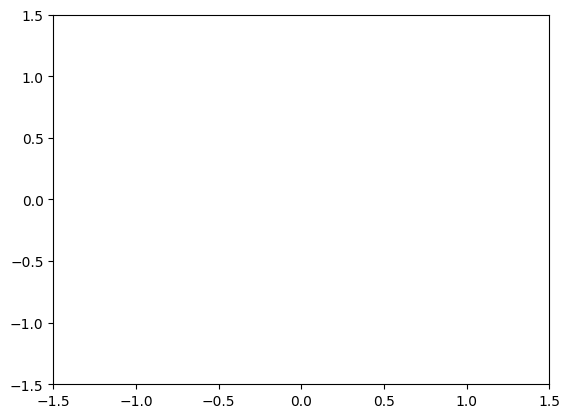

In [213]:

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

fig, ax = plt.subplots()
def init():
  ax.clear()
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(-1.5,1.5)

def Update(i):

    init()

    for j, p in enumerate(Orbitantes):

        r_over_time =p.GetPosition(scale)[i,0]
        theta_over_time = p.GetPosition(scale)[i,1]

        x, y = polar_to_cartesian(r_over_time, theta_over_time)
        ax.scatter(0,0,s=100,color='g')

        colors = ['r','k','b']
        ax.scatter(x,y,color=colors[j])

        circle = plt.Circle((x,y),0.05,color=colors[j],fill=True)
        ax.add_patch(circle)

Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)
HTML(Animation.to_html5_video())